In [1]:
# Author Bereket Kebede, Graduate Student
# Neural Networks -  Assignment #3 - University of Memphis. Fall 2021
# Question #1, Transfer Learnining, ResNet50 on TinyImage
# Last updated - Oct 10, 2021

In [2]:
#####################################################################################
# Import necessary libraries

import time
import scipy.ndimage as nd
import imageio 
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, MaxPool2D, Flatten
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from sklearn.ensemble import VotingClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
import tensorflow as tf

In [3]:
#####################################################################################
# Load Training and Testing data, TinyImageNet

path = 'C:/Users/CIRL/Desktop/Bereket/Neural Networks/Assignment 3/archive/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [cv2.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(cv2.imread( path + 'val/images/{}'.format(img_name)))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)
  
train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())

print( "train data shape: ",  train_data.shape )
print( "train label shape: ", train_labels.shape )
print( "test data shape: ",   test_data.shape )
print( "test_labels.shape: ", test_labels.shape )

starting loading data
finished loading data, in 13.544842958450317 seconds
train data shape:  (100000, 64, 64, 3)
train label shape:  (100000, 200)
test data shape:  (10000, 64, 64, 3)
test_labels.shape:  (10000, 200)


In [4]:
#####################################################################################
# Shuffle data

def shuffle_data(train_data, train_labels ):
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)

    return train_data[train_idx], train_labels[train_idx]
  
train_data, train_labels = shuffle_data(train_data, train_labels)

In [5]:
#####################################################################################
# pre-processing data

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('resnet50_tiny_ImageNet.csv')

batch_size = 500
nb_classes = 200
nb_epoch = 10

# input image dimensions
img_rows, img_cols = 64, 64
# The images are RGB
img_channels = 3
# The data, shuffled and split between train and test sets:
X_train = train_data
Y_train = train_labels
X_test = test_data
Y_test = test_labels

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

In [23]:
#####################################################################################
# Data augmentation

datagen = ImageDataGenerator(
          featurewise_center=False,           # set input mean to 0 over the dataset
          samplewise_center=False,            # set each sample mean to 0
          featurewise_std_normalization=False,# divide inputs by std of the dataset
          samplewise_std_normalization=False, # divide each input by its std
          zca_whitening=False,                # apply ZCA whitening
          rotation_range=0,                   # randomly rotate images in the range (degrees, 0 to 180)
          width_shift_range=0.1,              # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,             # randomly shift images vertically (fraction of total height)
          horizontal_flip=True,               # randomly flip images
          vertical_flip=False )               # randomly flip images

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit( X_train )

print('Data augemntation done')

Data augemntation done


In [24]:
#####################################################################################
# Load pre-trained models

model_a = keras.models.load_model("model_resnet50.h5")
model_a._name = 'model_resnet50'
model_b = keras.models.load_model("model_resnet50_fine_tuned.h5")
model_b._name = 'model_resnet50_fine_tuned'
model_c = keras.models.load_model("best_DCNN_15.h5")

model1 = KerasClassifier(model_a , epochs = 10)
model2 = KerasClassifier(model_b , epochs = 10)
model3 = KerasClassifier(model_c , epochs = 10)

model1._estimator_type = "classifier"
model2._estimator_type = "classifier"
model3._estimator_type = "classifier"

In [30]:
commonInput = Input(shape=(64,64,3))
out1 = model_a(commonInput)
out2 = model_b(commonInput)
out3 = model_c(Input(shape=(224,224,1)))
merged = keras.layers.Add()([out1,out2])
newModel = tf.keras.Model(commonInput, merged)

In [31]:
epoch =10
newModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = newModel.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                     steps_per_epoch=X_train.shape[0] // batch_size,
                     validation_data=(X_test, Y_test),
                     epochs=epoch, verbose=1,
                     callbacks=[lr_reducer, early_stopper, csv_logger] )

Epoch 1/10
200/200 [==============================] - 96s 448ms/step - loss: 0.4163 - accuracy: 0.8911 - val_loss: 2.6346 - val_accuracy: 0.4904
Epoch 2/10
200/200 [==============================] - 90s 447ms/step - loss: 0.4547 - accuracy: 0.8800 - val_loss: 2.5944 - val_accuracy: 0.5057
Epoch 3/10
200/200 [==============================] - 90s 450ms/step - loss: 0.4523 - accuracy: 0.8798 - val_loss: 2.6447 - val_accuracy: 0.5016
Epoch 4/10
200/200 [==============================] - 91s 452ms/step - loss: 0.4401 - accuracy: 0.8842 - val_loss: 2.5734 - val_accuracy: 0.5104
Epoch 5/10
200/200 [==============================] - 91s 453ms/step - loss: 0.4340 - accuracy: 0.8868 - val_loss: 2.6847 - val_accuracy: 0.5056
Epoch 6/10
200/200 [==============================] - 91s 454ms/step - loss: 0.4123 - accuracy: 0.8935 - val_loss: 2.5843 - val_accuracy: 0.5148
Epoch 7/10
200/200 [==============================] - 91s 456ms/step - loss: 0.3963 - accuracy: 0.8995 - val_loss: 2.6708 - val_ac

In [33]:
scores = newModel.evaluate(X_test, Y_test, verbose=1)
print('\nAccuracy:', scores[1])


313/313 [==============================] - 7s 24ms/step - loss: 2.4365 - accuracy: 0.5663

Accuracy: 0.5662999749183655


Plotting training loss



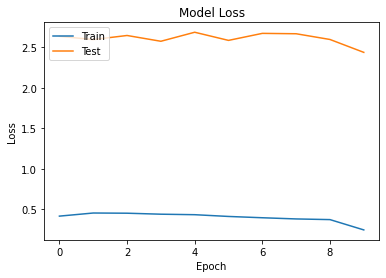

Plotting training accuracy



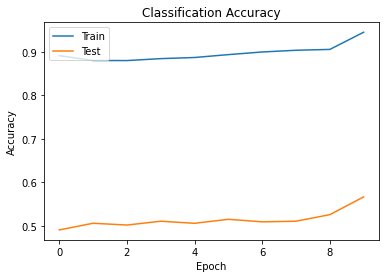

In [34]:
#####################################################################################
# Plotting training loss

print('Plotting training loss\n')
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#####################################################################################
# Plotting training accuracy

print('Plotting training accuracy\n')
plt.plot(history.history['accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()